<a href="https://colab.research.google.com/github/asqarqyzy/hello-world/blob/main/Test_case_DA_Nurlybayeva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data & libraries load

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df_arpu_monthly = pd.read_csv("/content/drive/MyDrive/test_case_DataMiner_2_variant/test_case_for_DM_2/data/arpu_monthly.csv")
df_change_tariff = pd.read_csv("/content/drive/MyDrive/test_case_DataMiner_2_variant/test_case_for_DM_2/data/change_tariff.csv")
df_dict_tariff = pd.read_csv("/content/drive/MyDrive/test_case_DataMiner_2_variant/test_case_for_DM_2/data/dict_tariff.csv")
df_traffic = pd.read_csv("/content/drive/MyDrive/test_case_DataMiner_2_variant/test_case_for_DM_2/data/traffic.csv",
                         parse_dates=["date_issue_device","time_key"],
                         date_format='mixed')

In [ ]:
df_arpu_monthly_test = pd.read_csv("/content/drive/MyDrive/test_case_DataMiner_2_variant/test_case_for_DM_2/test_data/arpu_monthly_test.csv")
df_change_tariff_test = pd.read_csv("/content/drive/MyDrive/test_case_DataMiner_2_variant/test_case_for_DM_2/test_data/change_tariff_test.csv")
df_traffic_test = pd.read_csv("/content/drive/MyDrive/test_case_DataMiner_2_variant/test_case_for_DM_2/test_data/traffic_test.csv",
                         parse_dates=["date_issue_device","time_key"],
                         date_format='mixed')

In [ ]:
traffic_train_in = df_traffic["ID_NUMBER"].unique().tolist()
traffic_test_in = df_traffic_test["ID_NUMBER"].unique().tolist()
print("df_traffic")
print("Количество уникальных записей абонента в train dataset:", len(traffic_train_in))
print("Количество уникальных записей абонента в test dataset:", len(traffic_test_in))
traffic_train_in.extend(traffic_test_in)
print("Количество записей абонента в train + test dataset:", len(traffic_train_in))
print("Количество уникальных записей абонента в train + test dataset:", len(set(traffic_train_in)))

df_traffic
Количество уникальных записей абонента в train dataset: 14875
Количество уникальных записей абонента в test dataset: 23346
Количество записей абонента в train + test dataset: 38221
Количество уникальных записей абонента в train + test dataset: 38221


In [ ]:
arpu_train_in = df_arpu_monthly["ID_NUMBER"].unique().tolist()
arpu_test_in = df_arpu_monthly_test["ID_NUMBER"].unique().tolist()
print("df_arpu_monthly")
print("Количество уникальных записей абонента в train dataset:", len(arpu_train_in))
print("Количество уникальных записей абонента в test dataset:", len(arpu_test_in))
arpu_train_in.extend(arpu_test_in)
print("Количество записей абонента в train + test dataset:", len(arpu_train_in))
print("Количество уникальных записей абонента в train + test dataset:", len(set(arpu_train_in)))

df_arpu_monthly
Количество уникальных записей абонента в train dataset: 14991
Количество уникальных записей абонента в test dataset: 23441
Количество записей абонента в train + test dataset: 38432
Количество уникальных записей абонента в train + test dataset: 38432


In [ ]:
change_train_in = df_change_tariff["ID_NUMBER"].unique().tolist()
change_test_in = df_change_tariff_test["ID_NUMBER"].unique().tolist()
print("df_change_tariff")
print("Количество уникальных записей абонента в train dataset:", len(change_train_in))
print("Количество уникальных записей абонента в test dataset:", len(change_test_in))
change_train_in.extend(change_test_in)
print("Количество записей абонента в train + test dataset:", len(change_train_in))
print("Количество уникальных записей абонента в train + test dataset:", len(set(change_train_in)))

df_change_tariff
Количество уникальных записей абонента в train dataset: 14817
Количество уникальных записей абонента в test dataset: 22135
Количество записей абонента в train + test dataset: 36952
Количество уникальных записей абонента в train + test dataset: 36952


Train и Test dataset- ы не пересекаются по абонентам, то есть независимы и можно будет заполнять пустые значения по частоте не разделяя на dataframe-ы.

# Concatenate Train and Test datasets

In [ ]:
# Concatenate Train and test datasets
df_arpu_monthly = pd.concat([df_arpu_monthly, df_arpu_monthly_test])
df_change_tariff = pd.concat([df_change_tariff, df_change_tariff_test])
df_traffic = pd.concat([df_traffic, df_traffic_test])

df_arpu_monthly["TIME_KEY"] = pd.to_datetime(df_arpu_monthly["TIME_KEY"])

# Set order for imputing missing data - bfill/ffill
df_traffic = df_traffic.sort_values(["ID_NUMBER", "time_key"]).reset_index(drop=True)

# EDA of train datasets

## **df_arpu_monthly**
-- *выручка на абонента на каждый месяц*
*   **ARPU_1M** - Выручка на абонента за месяц
*   **TIME_KEY** - Месяц агрегации
*   **ID_NUMBER** - Номер абонента

In [ ]:
df_arpu_monthly.head()

,ARPU_1M,TIME_KEY,ID_NUMBER
0,11.62,2019-08-01,5746
1,842.68,2019-06-01,5746
2,266.33,2019-07-01,5746
3,36.46,2019-09-01,5746
4,263.32,2019-05-01,5746


In [ ]:
df_arpu_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 208981 entries, 0 to 130182
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   ARPU_1M    208981 non-null  float64       
 1   TIME_KEY   208981 non-null  datetime64[ns]
 2   ID_NUMBER  208981 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 6.4 MB


In [ ]:
df_arpu_monthly["TIME_KEY"] = pd.to_datetime(df_arpu_monthly["TIME_KEY"])

In [ ]:
df_arpu_monthly.ID_NUMBER.value_counts()

ID_NUMBER
17220    35
2927     24
38599    24
27892    21
19156    21
         ..
19228     1
25817     1
35711     1
19267     1
2745      1
Name: count, Length: 38432, dtype: int64

In [ ]:
df_arpu_monthly[df_arpu_monthly.ID_NUMBER == 11209].sort_values("TIME_KEY")

,ARPU_1M,TIME_KEY,ID_NUMBER
538,896.41,2019-04-01,11209
539,896.41,2019-04-01,11209
534,0.00,2019-05-01,11209
535,0.00,2019-05-01,11209
544,0.00,2019-06-01,11209
545,0.00,2019-06-01,11209
536,413.35,2019-07-01,11209
537,413.35,2019-07-01,11209
540,8422.05,2019-08-01,11209
541,8422.05,2019-08-01,11209


Есть дубликаты observations по номеру телефона в разрезе отчетного месяца.

In [ ]:
df_arpu_monthly = df_arpu_monthly.drop_duplicates()

84 записи удалено в связи с дублями.

In [ ]:
df_arpu_monthly.ID_NUMBER.value_counts()

ID_NUMBER
38599    8
30955    8
30914    8
16408    8
34839    8
        ..
19278    1
33382    1
33262    1
21327    1
2626     1
Name: count, Length: 38432, dtype: int64

In [ ]:
df_arpu_monthly[df_arpu_monthly.ID_NUMBER == 24379].sort_values("TIME_KEY")

,ARPU_1M,TIME_KEY,ID_NUMBER
22063,5771.45,2019-04-01,24379
22060,5646.79,2019-05-01,24379
22061,0.00,2019-05-01,24379
22064,0.00,2019-06-01,24379
22065,0.00,2019-07-01,24379
22059,0.00,2019-08-01,24379
22062,375.92,2019-09-01,24379
22066,0.00,2019-09-01,24379


На примере номера абонента "24379", данные не сгруппированы относительно абонента в мае и сентябре. Необходимо агрегировать данные повторно.

In [ ]:
df_arpu_monthly = df_arpu_monthly.groupby(["TIME_KEY", "ID_NUMBER"]).sum("ARPU_1M").reset_index()

Количество записей снизилось с 78713 до 78446 на 267 записи.

In [ ]:
df_arpu_monthly.isna().sum()

TIME_KEY     0
ID_NUMBER    0
ARPU_1M      0
dtype: int64

Пустых значений нет.

In [ ]:
stats_ARPU_1M = df_arpu_monthly["ARPU_1M"].describe()
stats_ARPU_1M

count    2.037180e+05
mean     5.004945e+03
std      8.383078e+03
min     -5.411500e+02
25%      5.996275e+02
50%      4.639920e+03
75%      6.784630e+03
max      1.417083e+06
Name: ARPU_1M, dtype: float64

В показателе ARPU_1M есть outliers т.к. максимальное значение не лежит в диапозоне 3 std.

<Axes: >

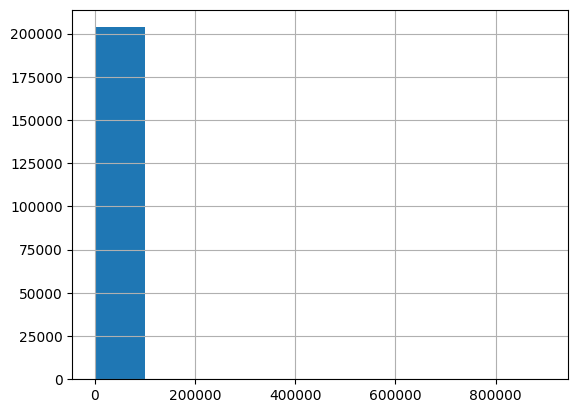

In [ ]:
df_arpu_monthly["ARPU_1M"].hist(bins=range(0, 10**6, 10**5))

In [ ]:
# upper_treshold = stats_ARPU_1M["mean"] + stats_ARPU_1M["std"] * 3
# lower_treshold = stats_ARPU_1M["mean"] - stats_ARPU_1M["std"] * 3
# df_arpu_monthly[(df_arpu_monthly["ARPU_1M"] > upper_treshold)  | (df_arpu_monthly["ARPU_1M"] < lower_treshold)].sort_values("ARPU_1M", ascending=False)
upper_treshold = 10**5
df_arpu_monthly[df_arpu_monthly["ARPU_1M"] > upper_treshold].sort_values("ARPU_1M", ascending=False)


,TIME_KEY,ID_NUMBER,ARPU_1M
191872,2020-01-01,19746,1417082.91
195454,2020-01-01,25307,1306293.44
179869,2019-12-01,38689,1020132.75
60697,2019-08-01,14237,976802.76
191930,2020-01-01,19819,942616.32
52951,2019-08-01,4892,925060.45
188786,2020-01-01,14718,649859.46
189118,2020-01-01,15250,541922.55
191279,2020-01-01,18851,538987.44
95989,2019-09-01,17039,491386.92


In [ ]:
df_arpu_monthly[df_arpu_monthly.ID_NUMBER == 14237].sort_values("TIME_KEY")

,TIME_KEY,ID_NUMBER,ARPU_1M
4182,2019-04-01,14237,4144.96
16062,2019-05-01,14237,3444.17
28281,2019-06-01,14237,6520.62
41159,2019-07-01,14237,6103.88
60697,2019-08-01,14237,976802.76
93472,2019-09-01,14237,18591.69


Необходимо обратиться к дата-коллектору и бизнес подразделению чтобы удостовериться в действительности  ARPU_1M абонента ID_NUMBER=14237, у которого выброс в августе 976802 и значительно отличается от других месяцев. Временно откоректируем значение.


In [ ]:
df_arpu_monthly.iloc[54539, 2] = df_arpu_monthly.iloc[54539, 2] / 100.0

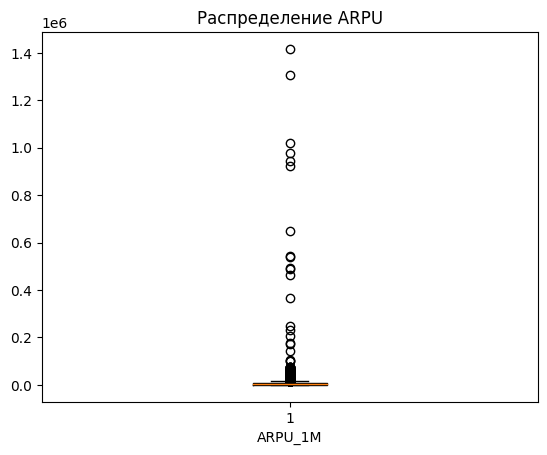

In [ ]:
plt.boxplot(df_arpu_monthly["ARPU_1M"])
plt.title("Распределение ARPU")
plt.xlabel("ARPU_1M")
plt.show()

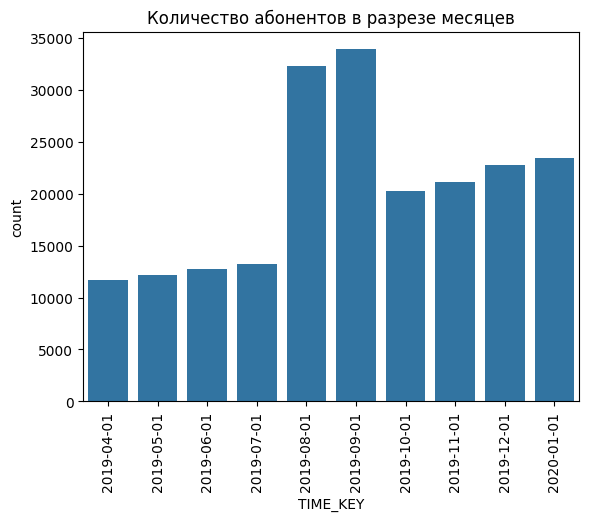

In [ ]:
g = sns.countplot(x="TIME_KEY", data=df_arpu_monthly)
g.set_title("Количество абонентов в разрезе месяцев")
plt.xticks(rotation=90)
plt.show()

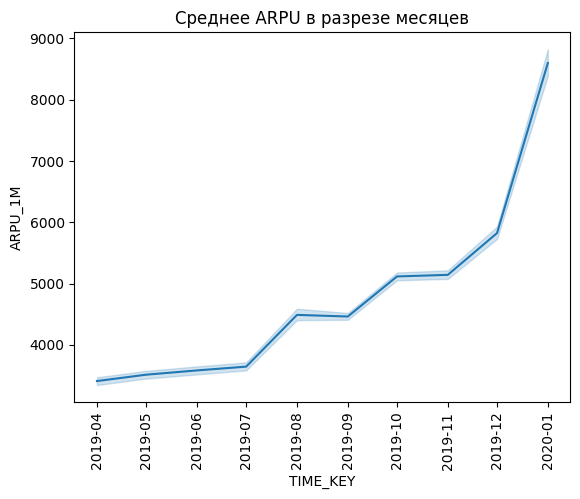

In [ ]:
g = sns.lineplot(x="TIME_KEY", y="ARPU_1M", data=df_arpu_monthly)
g.set_title("Среднее ARPU в разрезе месяцев")
plt.xticks(rotation=90)
plt.show()

Для train данные собраны за 6 месяцев апрель-сентябрь 2019 года.

## **df_change_tariff**
-- *все смены тарифных планов за месяц*
*   **TIME_KEY** - Месяц агрегации
*   **ID_NUMBER** - Номер телефона
*   **AVG_ARPU_PREV_3M** - Среднее АРПУ за 3 месяца до смены
*   **AVG_ARPU_NEXT_3M** - Среднее АРПУ за 3 месяца после смены
*   **tariff_plan_code_from** - Тарифный план с которого перешел абонент
*   **tariff_plan_code_to** - Тарифный план на который перешел абонент

In [ ]:
df_change_tariff.head()

,TIME_KEY,AVG_ARPU_PREV_3M,AVG_ARPU_NEXT_3M,ID_NUMBER,tariff_plan_code_from,tariff_plan_code_to,DIRECTION_OF_CHANGE
0,2019-10-01 00:00:00.0,104.80,3466.71,5746,tariff_8,tariff_9,NaN
1,2019-10-01 00:00:00.0,1942.23,2789.06,11102,tariff_2,tariff_13,NaN
2,2019-10-01 00:00:00.0,4485.72,5500.61,13477,tariff_18,tariff_8,NaN
3,2019-10-01 00:00:00.0,1959.71,10069.25,16127,tariff_8,tariff_10,NaN
4,2019-10-01 00:00:00.0,1337.31,862.58,16626,tariff_8,tariff_10,NaN


In [ ]:
df_change_tariff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37496 entries, 0 to 22672
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   TIME_KEY               14823 non-null  object 
 1   AVG_ARPU_PREV_3M       37496 non-null  float64
 2   AVG_ARPU_NEXT_3M       37496 non-null  float64
 3   ID_NUMBER              37496 non-null  int64  
 4   tariff_plan_code_from  37496 non-null  object 
 5   tariff_plan_code_to    37496 non-null  object 
 6   DIRECTION_OF_CHANGE    22673 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 3.3+ MB


In [ ]:
df_change_tariff.ID_NUMBER.value_counts()

ID_NUMBER
17220    5
2927     3
10142    3
24944    3
2744     3
        ..
31235    1
22829    1
19812    1
16723    1
37575    1
Name: count, Length: 36952, dtype: int64

In [ ]:
df_change_tariff[df_change_tariff["ID_NUMBER"] == 2121]

,TIME_KEY,AVG_ARPU_PREV_3M,AVG_ARPU_NEXT_3M,ID_NUMBER,tariff_plan_code_from,tariff_plan_code_to,DIRECTION_OF_CHANGE
2338,2019-10-01 00:00:00.0,799.66,3976.44,2121,tariff_15,tariff_9,NaN
2339,2019-10-01 00:00:00.0,799.66,3976.44,2121,tariff_15,tariff_9,NaN


In [ ]:
df_change_tariff = df_change_tariff.drop_duplicates()
df_change_tariff.ID_NUMBER.value_counts().max()

3

Удалено 6 записей в связи с дублями, максимальное количество смены тарифа у абонентов в рассматриваемом месяце - один раз.

In [ ]:
df_change_tariff.isna().sum()

TIME_KEY                 22228
AVG_ARPU_PREV_3M             0
AVG_ARPU_NEXT_3M             0
ID_NUMBER                    0
tariff_plan_code_from        0
tariff_plan_code_to          0
DIRECTION_OF_CHANGE      14817
dtype: int64

Пустых значений нет.

In [ ]:
df_change_tariff["TIME_KEY"].value_counts()

TIME_KEY
2019-10-01 00:00:00.0    14817
Name: count, dtype: int64

Данные по смене тарифа за октябрь 2019 года. Можем удалить поле в связи остутствием альтернативных значений.

In [ ]:
df_change_tariff.drop("TIME_KEY", axis=1, inplace=True)

<ipython-input-269-140b335cb70f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_change_tariff.drop("TIME_KEY", axis=1, inplace=True)


In [ ]:
df_change_tariff[["AVG_ARPU_PREV_3M", "AVG_ARPU_NEXT_3M"]].describe()

,AVG_ARPU_PREV_3M,AVG_ARPU_NEXT_3M
count,37045.000000,37045.000000
mean,4535.718177,4855.314418
std,4556.239159,4938.108776
min,-37.410000,0.000000
25%,1401.790000,1247.630000
50%,4205.350000,4110.270000
75%,6661.480000,7152.900000
max,342225.330000,337497.670000


AVG_ARPU_PREV_3M имеет максимальное значение выше среднего в 100 раз.

In [ ]:
df_change_tariff[df_change_tariff["AVG_ARPU_PREV_3M"] > 50000]

,AVG_ARPU_PREV_3M,AVG_ARPU_NEXT_3M,ID_NUMBER,tariff_plan_code_from,tariff_plan_code_to,DIRECTION_OF_CHANGE
4435,333832.77,15023.16,14237,tariff_8,tariff_10,NaN
6573,55495.00,0.00,33734,tariff_10,tariff_1,NaN
4626,342225.33,3195.98,38689,tariff_8,tariff_13,DOWNSELL
5153,52641.90,17090.79,35521,tariff_10,tariff_11,DOWNSELL
5411,57497.61,28718.74,23742,tariff_11,tariff_10,DOWNSELL
5589,57736.89,31413.30,26746,tariff_1,tariff_11,DOWNSELL
9489,55494.59,31109.59,22055,tariff_11,tariff_10,DOWNSELL
20120,79737.08,2839.23,20605,tariff_8,tariff_13,DOWNSELL
22505,54368.48,47148.36,2907,tariff_8,tariff_12,DOWNSELL


In [ ]:
df_arpu_monthly[df_arpu_monthly['ID_NUMBER'] == 14237]

,TIME_KEY,ID_NUMBER,ARPU_1M
4182,2019-04-01,14237,4144.96
16062,2019-05-01,14237,3444.17
28281,2019-06-01,14237,6520.62
41159,2019-07-01,14237,6103.88
60697,2019-08-01,14237,976802.76
93472,2019-09-01,14237,18591.69


Перепроверили с df_arpu_monthly и пересчитали в связи с ручной корректировкой в df_arpu_monthly.

In [ ]:
df_change_tariff.iloc[4435, 1] = df_arpu_monthly[(df_arpu_monthly['ID_NUMBER'] == 14237) & \
                                    (df_arpu_monthly['TIME_KEY'] >= "2019-07-01")]["ARPU_1M"].mean()

<Axes: >

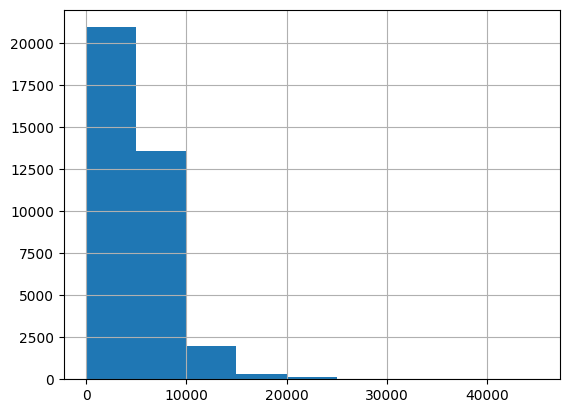

In [ ]:
df_change_tariff["AVG_ARPU_PREV_3M"].hist(bins=range(0, 50000, 5000))

<Axes: >

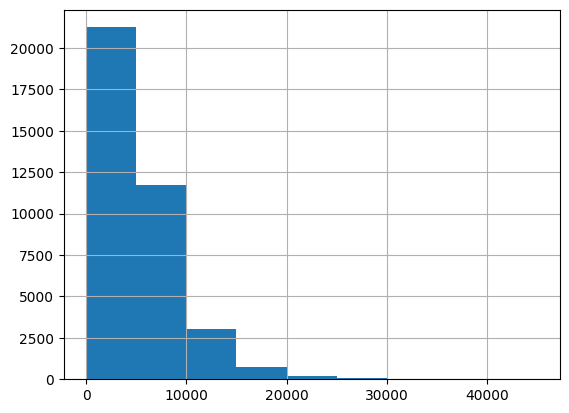

In [ ]:
df_change_tariff["AVG_ARPU_NEXT_3M"].hist(bins=range(0, 50000, 5000))

In [ ]:
df_change_tariff.tariff_plan_code_from.value_counts()

tariff_plan_code_from
tariff_8     6942
tariff_10    4153
tariff_11    2918
tariff_4     2826
tariff_15    2212
tariff_5     2116
tariff_3     2063
tariff_12    1958
tariff_7     1324
tariff_1     1225
tariff_6     1169
tariff_13    1132
tariff_14    1091
tariff_18    1058
tariff_17     996
tariff_9      958
tariff_16     866
tariff_2      726
tariff_19     678
tariff_20     634
Name: count, dtype: int64

In [ ]:
df_change_tariff.tariff_plan_code_to.value_counts()

tariff_plan_code_to
tariff_8     11737
tariff_4      5753
tariff_10     5671
tariff_13     3891
tariff_11     3641
tariff_12     1902
tariff_14     1807
tariff_9      1441
tariff_1       883
tariff_21      318
tariff_16        1
Name: count, dtype: int64

## **df_dict_tariff**
-- *справочник тарифов*

*   **Data_in_PKG** - Количество мегабайтов в тарифе
*   **Min_another_operator_in_PKG** - Количество минут в тарифе, звонки на номера других операторов
*   **Min_another_operator_and_city_in_PKG** - Количество минут в тарифе, звонки на номера других операторов и городские номера
*   **price_tariff** - Стоимость тарифного плана
*   **tariff_plan_code** - Код тарифного плана





In [ ]:
df_dict_tariff

,Data_in_PKG,Min_another_operator_in_PKG,Min_another_operator_and_city_in_PKG,price_tariff,tariff_plan_code
0,0,0,0,0.0,tariff_1
1,2048,0,0,3140.0,tariff_2
2,10240,80,0,5620.6,tariff_3
3,4096,40,0,4678.6,tariff_4
4,8192,80,0,5934.6,tariff_5
5,8192,80,0,5934.6,tariff_6
6,8192,80,0,5934.6,tariff_7
7,8192,80,0,5934.6,tariff_8
8,10240,150,0,4364.6,tariff_9
9,12288,120,0,7504.6,tariff_10


In [ ]:
df_dict_tariff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Data_in_PKG                           21 non-null     int64  
 1   Min_another_operator_in_PKG           21 non-null     int64  
 2   Min_another_operator_and_city_in_PKG  21 non-null     int64  
 3   price_tariff                          21 non-null     float64
 4   tariff_plan_code                      21 non-null     object 
dtypes: float64(1), int64(3), object(1)
memory usage: 968.0+ bytes


In [ ]:
df_dict_tariff.describe()

,Data_in_PKG,Min_another_operator_in_PKG,Min_another_operator_and_city_in_PKG,price_tariff
count,21.000000,21.000000,21.000000,21.000000
mean,9313.523810,81.904762,14.285714,5725.266667
std,7791.185017,57.586374,65.465367,2504.911916
min,0.000000,0.000000,0.000000,0.000000
25%,3072.000000,40.000000,0.000000,4364.600000
50%,8192.000000,80.000000,0.000000,5934.600000
75%,12288.000000,100.000000,0.000000,6562.600000
max,30720.000000,200.000000,300.000000,12528.600000


## **df_traffic**
-- *параметры по биллингу за 6 месяцев*
* **ID_NUMBER** - Номер абонента
* **time_key** - Месяц агрегации
* **OUT_LOC_** *  - Параметры отвечающие за потребление минут
* **OUT_LOCAL_** *  - Параметры отвечающие за потребление смс
* **DATA_VOLUME** - Общее количество gprs трафика
* **LTE_DATA_VOLUME** - Общее количество 4g gprs трафика
* **TOTAL_ROAM_** * - Параметры отвечающие за траффик в роуминге
* **COUNT_CONTACT** - Уникальное количество контактов за месяц
* **AVG_TRANSACT_CONTACT** - Среднее количество транзакций среди всех контактных номеров
* **SUM_TRANSACT_CONTACT** - Суммарное количество транзакций среди всех контактных номеров
* **AVG_DURATION_CONTACT** - Средняя продолжительность звонков среди всех контактов
* **COUNT_BASE_STATION** - Количество базовых станций за месяц
* **tariff_plan_code** - Тарифный план в этом месяце
* **FIRST_DISP_DIAG** - Диагональ телефона активного в этом месяце
* **OS_** * - ОС телефона
* **date_issue_device** -  Дата выпуска устройства


In [ ]:
df_traffic.head()

,DEVICE_ID,time_key,OUT_LOC_ONNET_MIN,OUT_LOC_OFFNET_MIN,OUT_LOC_OFFNET_UNPAID_MIN,OUT_LOC_OFFNET_PAID_MIN,OUT_INTER_MIN,OUT_LOC_LAND_MIN,OUT_LOCAL_ONNET_SMS_AMT,OUT_LOCAL_OFFNET_SMS_AMT,...,AVG_DURATION_CONTACT,COUNT_BASE_STATION,FIRST_DISP_DIAG,OS_1,OS_2,OS_3,OS_4,date_issue_device,ID_NUMBER,tariff_plan_code
0,35843007.0,2019-04-01,211.38,100.56,99.63,0.93,0.08,6.95,5.0,1.0,...,843.433333,20.0,5.1,0.0,1.0,0.0,0.0,2015-11-18,1001,tariff_10
1,35843007.0,2019-05-01,188.26,125.07,125.07,0.00,0.00,5.43,3.0,0.0,...,890.333333,20.0,5.1,0.0,1.0,0.0,0.0,2015-11-18,1001,tariff_10
2,35843007.0,2019-06-01,273.97,154.28,147.45,6.83,0.00,11.22,4.0,1.0,...,1037.266667,20.0,5.1,0.0,1.0,0.0,0.0,2015-11-18,1001,tariff_10
3,86989004.0,2019-07-01,157.17,130.34,114.77,15.57,0.00,7.68,5.0,0.0,...,807.500000,20.0,6.4,0.0,1.0,0.0,0.0,2019-01-14,1001,tariff_12
4,86989004.0,2019-08-01,176.40,116.88,116.88,0.00,0.00,35.07,1.0,0.0,...,848.033333,20.0,6.4,0.0,1.0,0.0,0.0,2019-01-14,1001,tariff_12


In [ ]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192418 entries, 0 to 192417
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   DEVICE_ID                    185869 non-null  float64       
 1   time_key                     192418 non-null  datetime64[ns]
 2   OUT_LOC_ONNET_MIN            192418 non-null  float64       
 3   OUT_LOC_OFFNET_MIN           192418 non-null  float64       
 4   OUT_LOC_OFFNET_UNPAID_MIN    192418 non-null  float64       
 5   OUT_LOC_OFFNET_PAID_MIN      192418 non-null  float64       
 6   OUT_INTER_MIN                192418 non-null  float64       
 7   OUT_LOC_LAND_MIN             192418 non-null  float64       
 8   OUT_LOCAL_ONNET_SMS_AMT      192418 non-null  float64       
 9   OUT_LOCAL_OFFNET_SMS_AMT     192418 non-null  float64       
 10  OUT_LOCAL_LAND_PAID_SMS_AMT  192418 non-null  float64       
 11  OUT_INTER_SMS_AMT         

In [ ]:
df_traffic[df_traffic["ID_NUMBER"] == 5746].sort_values("time_key")

,DEVICE_ID,time_key,OUT_LOC_ONNET_MIN,OUT_LOC_OFFNET_MIN,OUT_LOC_OFFNET_UNPAID_MIN,OUT_LOC_OFFNET_PAID_MIN,OUT_INTER_MIN,OUT_LOC_LAND_MIN,OUT_LOCAL_ONNET_SMS_AMT,OUT_LOCAL_OFFNET_SMS_AMT,...,AVG_DURATION_CONTACT,COUNT_BASE_STATION,FIRST_DISP_DIAG,OS_1,OS_2,OS_3,OS_4,date_issue_device,ID_NUMBER,tariff_plan_code
23422,35520606.0,2019-04-01,400.42,53.13,53.13,0.0,0.0,3.32,22.0,0.0,...,1142.533333,20.0,5.1,0.0,1.0,0.0,0.0,2014-05-29,5746,tariff_8
23423,35520606.0,2019-05-01,102.95,6.98,6.98,0.0,0.0,0.72,9.0,0.0,...,401.800000,20.0,5.1,0.0,1.0,0.0,0.0,2014-05-29,5746,tariff_8
23424,35520606.0,2019-06-01,19.45,0.00,0.00,0.0,0.0,0.68,0.0,0.0,...,180.238095,7.0,5.1,0.0,1.0,0.0,0.0,2014-05-29,5746,tariff_8
23425,35520606.0,2019-07-01,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,...,146.611111,4.0,5.1,0.0,1.0,0.0,0.0,2014-05-29,5746,tariff_8
23426,35463910.0,2019-08-01,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,...,150.200000,7.0,6.4,0.0,1.0,0.0,0.0,2018-11-21,5746,tariff_8
23427,35463810.0,2019-09-01,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,...,149.750000,9.0,6.4,0.0,1.0,0.0,0.0,2018-11-21,5746,tariff_8


Описание характеристик абонента на ежемемесяной основе с апреля по сентябрь 2019.

In [ ]:
df_traffic.time_key.value_counts().sort_values()

time_key
2019-04-01    11296
2019-05-01    11621
2019-06-01    11998
2019-07-01    12781
2019-10-01    18446
2019-11-01    19850
2019-12-01    22281
2020-01-01    22495
2019-08-01    29697
2019-09-01    31953
Name: count, dtype: int64

In [ ]:
df_traffic.describe()

,DEVICE_ID,time_key,OUT_LOC_ONNET_MIN,OUT_LOC_OFFNET_MIN,OUT_LOC_OFFNET_UNPAID_MIN,OUT_LOC_OFFNET_PAID_MIN,OUT_INTER_MIN,OUT_LOC_LAND_MIN,OUT_LOCAL_ONNET_SMS_AMT,OUT_LOCAL_OFFNET_SMS_AMT,...,AVG_TRANSACT_CONTACT,SUM_TRANSACT_CONTACT,AVG_DURATION_CONTACT,COUNT_BASE_STATION,FIRST_DISP_DIAG,OS_1,OS_2,OS_3,OS_4,ID_NUMBER
count,1.858690e+05,192418,192418.000000,192418.000000,192418.000000,192418.000000,192418.000000,192418.000000,192418.000000,192418.000000,...,183432.000000,183432.000000,183432.000000,187946.000000,177844.000000,178306.000000,178306.000000,178306.000000,178306.000000,192418.000000
mean,4.979256e+07,2019-09-03 22:03:24.679395584,211.771151,39.800123,32.571180,7.228943,0.903297,0.867956,1.774257,0.524603,...,9.210200,228.122863,1172.568894,16.786316,4.822881,0.087658,0.789031,0.121555,0.001755,20270.935256
min,-1.000000e+00,2019-04-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,-99.000000,0.000000,0.000000,0.000000,0.000000,1001.000000
25%,3.549171e+07,2019-08-01 00:00:00,4.270000,0.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.233333,64.000000,355.000000,16.000000,4.700000,0.000000,1.000000,0.000000,0.000000,10661.000000
50%,3.576761e+07,2019-09-01 00:00:00,71.730000,14.735000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.400000,170.000000,745.683333,20.000000,5.000000,0.000000,1.000000,0.000000,0.000000,20186.000000
75%,8.618620e+07,2019-11-01 00:00:00,269.697500,56.717500,48.730000,1.680000,0.000000,0.000000,1.000000,0.000000,...,12.100000,327.000000,1438.371154,20.000000,5.700000,0.000000,1.000000,0.000000,0.000000,30028.000000
max,9.900058e+07,2020-01-01 00:00:00,15790.900000,1564.660000,958.300000,1439.480000,704.180000,614.850000,562.000000,719.000000,...,622.000000,3671.000000,189869.666667,20.000000,10.500000,1.000000,1.000000,1.000000,1.000000,39444.000000
std,2.340882e+07,NaN,375.639878,62.126774,48.698922,28.504060,10.553395,4.362799,9.424160,3.876932,...,7.602266,217.490412,1837.627735,5.713772,3.556757,0.282798,0.407997,0.326772,0.041861,11150.250831


# Pvt_traffic

### Df_traffic - dealing with missing values

In [ ]:
null_traffic_stats = df_traffic.isna().sum().reset_index()
null_traffic_stats["frac"] = null_traffic_stats.iloc[:, 1] / df_traffic.shape[0] * 100
null_traffic_stats[null_traffic_stats[0] > 0]

,index,0,frac
0,DEVICE_ID,6549,3.403528
17,COUNT_CONTACT,8986,4.670041
18,AVG_TRANSACT_CONTACT,8986,4.670041
19,SUM_TRANSACT_CONTACT,8986,4.670041
20,AVG_DURATION_CONTACT,8986,4.670041
21,COUNT_BASE_STATION,4472,2.324107
22,FIRST_DISP_DIAG,14574,7.574135
23,OS_1,14112,7.334033
24,OS_2,14112,7.334033
25,OS_3,14112,7.334033


In [ ]:
# Interpolate values with linear method in both directions for numeric values
columns = ["ID_NUMBER", "COUNT_CONTACT", "AVG_TRANSACT_CONTACT", "SUM_TRANSACT_CONTACT", "AVG_DURATION_CONTACT",\
           "COUNT_BASE_STATION", "FIRST_DISP_DIAG"]
df_traffic[columns] = df_traffic.groupby("ID_NUMBER")[columns]\
 .apply(lambda x: x.interpolate(method="linear", limit_direction="both")).reset_index(drop=True)

In [ ]:
null_traffic_stats = df_traffic.isna().sum().reset_index()
null_traffic_stats["frac"] = null_traffic_stats.iloc[:, 1] / df_traffic.shape[0] * 100
null_traffic_stats[null_traffic_stats[0] > 0]

,index,0,frac
0,DEVICE_ID,6549,3.403528
17,COUNT_CONTACT,1747,0.907919
18,AVG_TRANSACT_CONTACT,1747,0.907919
19,SUM_TRANSACT_CONTACT,1747,0.907919
20,AVG_DURATION_CONTACT,1747,0.907919
21,COUNT_BASE_STATION,408,0.212038
22,FIRST_DISP_DIAG,5275,2.741428
23,OS_1,14112,7.334033
24,OS_2,14112,7.334033
25,OS_3,14112,7.334033


In [ ]:
# FIlling with "0" 1747 rows of full Nan in terms ob ID_NUMBER and OS columns
columns = ["COUNT_CONTACT", "AVG_TRANSACT_CONTACT", "SUM_TRANSACT_CONTACT", "AVG_DURATION_CONTACT",\
           "COUNT_BASE_STATION", "FIRST_DISP_DIAG",\
           "OS_1", "OS_2", "OS_3", "OS_4"]
df_traffic[columns] = df_traffic[columns].fillna(0)

In [ ]:
# Backward/Forward fill of "tariff_plan_code", "DEVICE_ID" columns for categorical values
df_traffic[["tariff_plan_code", "DEVICE_ID"]]= df_traffic.groupby("ID_NUMBER")[["tariff_plan_code", "DEVICE_ID"]].ffill().bfill()

In [ ]:
null_traffic_stats = df_traffic.isna().sum().reset_index()
null_traffic_stats["frac"] = null_traffic_stats.iloc[:, 1] / df_traffic.shape[0] * 100
null_traffic_stats[null_traffic_stats[0] > 0]

,index,0,frac


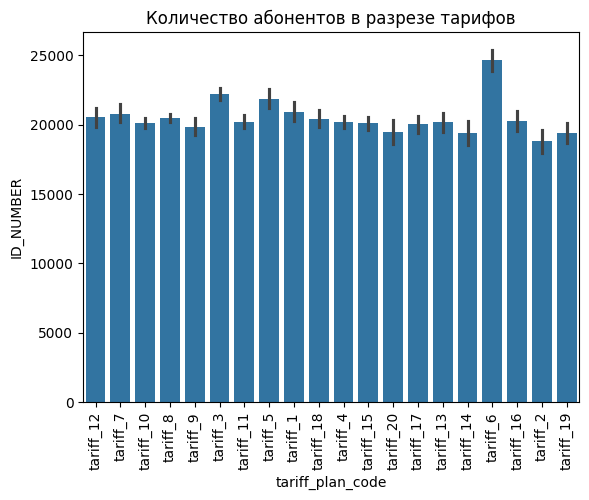

In [ ]:
g = sns.barplot(data=df_traffic[df_traffic.time_key == "2019-09-01"], x="tariff_plan_code", y="ID_NUMBER")
g.set_title("Количество абонентов в разрезе тарифов")
plt.xticks(rotation=90)
plt.show()

### Df_traffic --> pvt_traffic

In [ ]:
# Transforming time_key column to string category
conditions = [((df_traffic.time_key.dt.month == i) & df_traffic.ID_NUMBER.isin(traffic_train_in))
 | ((df_traffic.time_key.dt.month == i + 4 ) & df_traffic.ID_NUMBER.isin(traffic_test_in))
 for i in range(4, 10)]
categories = [str(i) +"mm" for i in range(0, 6)]
df_traffic["mm"] = np.select(conditions, categories, default="5mm")

df_traffic = df_traffic.drop("time_key", axis=1)

In [ ]:
# Column tariff_code count per client
df_tariff_count = df_traffic[["ID_NUMBER","tariff_plan_code"]].drop_duplicates().groupby("ID_NUMBER").count().reset_index()
df_tariff_count.rename(columns={"tariff_plan_code": "tariff_count"}, inplace=True)

In [ ]:
#Extracting tariff_code in ID format from "tariff_plan_code"
def get_tariff_code(tariff_name):
  tariff_code = [int(str(i).split("_")[1]) if len(str(i).split("_")) == 2 else -1 for i in tariff_name]
  return tariff_code

df_traffic["tariff_cd"] = get_tariff_code(df_traffic["tariff_plan_code"])
df_traffic.drop("tariff_plan_code", axis=1, inplace=True)

In [ ]:
# Columns by month
columns = ['TOTAL_ROAM_CALL_AMT', 'TOTAL_ROAM_SMS_AMT', 'TOTAL_ROAM_GPRS_MB',
       'COUNT_CONTACT', 'AVG_TRANSACT_CONTACT', 'SUM_TRANSACT_CONTACT',
       'AVG_DURATION_CONTACT', 'COUNT_BASE_STATION', "tariff_cd", 'OUT_LOC_ONNET_MIN', 'OUT_LOC_OFFNET_MIN',
       'OUT_LOC_OFFNET_UNPAID_MIN', 'OUT_LOC_OFFNET_PAID_MIN', 'OUT_INTER_MIN',
       'OUT_LOC_LAND_MIN', 'OUT_LOCAL_ONNET_SMS_AMT',
       'OUT_LOCAL_OFFNET_SMS_AMT', 'OUT_LOCAL_LAND_PAID_SMS_AMT',
       'OUT_INTER_SMS_AMT', 'DATA_VOLUME', 'LTE_DATA_VOLUME',
        "FIRST_DISP_DIAG",'OS_1','OS_2', 'OS_3', 'OS_4']
pvt_traffic = pd.pivot_table(df_traffic, values=columns, index="ID_NUMBER", columns="mm").fillna(0)
pvt_traffic.columns = pvt_traffic.columns.map('_'.join)
pvt_traffic.reset_index(inplace=True)

# Adding tariff_count
pvt_traffic = pvt_traffic.merge(df_tariff_count, on="ID_NUMBER", how="left")

# Copy for cohort analyses
df_cohort = pvt_traffic[~pvt_traffic["ID_NUMBER"].isin(traffic_test_in)][["ID_NUMBER",
'tariff_cd_0mm', 'tariff_cd_1mm', 'tariff_cd_2mm', 'tariff_cd_3mm', 'tariff_cd_4mm', 'tariff_cd_5mm']]

In [ ]:
# Columns with statistics
# columns = ['OUT_LOC_ONNET_MIN', 'OUT_LOC_OFFNET_MIN',
#        'OUT_LOC_OFFNET_UNPAID_MIN', 'OUT_LOC_OFFNET_PAID_MIN', 'OUT_INTER_MIN',
#        'OUT_LOC_LAND_MIN', 'OUT_LOCAL_ONNET_SMS_AMT',
#        'OUT_LOCAL_OFFNET_SMS_AMT', 'OUT_LOCAL_LAND_PAID_SMS_AMT',
#        'OUT_INTER_SMS_AMT', 'DATA_VOLUME', 'LTE_DATA_VOLUME']
# operations = ["sum", "mean", "max", "min"]
# for operation in operations:
#   dict_columns = {i: operation.upper() + "_" + i for i in columns}
#   pvt_traffic_join = pd.pivot_table(df_traffic, values=columns, index="ID_NUMBER", aggfunc=operation).reset_index()
#   pvt_traffic_join.rename(columns=dict_columns, inplace=True)
#   pvt_traffic = pvt_traffic.merge(pvt_traffic_join, how="left", on="ID_NUMBER")

In [ ]:
# Columns start-end points
dict_columns = {"date_issue_device": "MAX_date_issue_device"}
pvt_traffic_join = pd.pivot_table(df_traffic, values='date_issue_device', index="ID_NUMBER", aggfunc="max").reset_index().fillna(0)
pvt_traffic_join.rename(columns=dict_columns, inplace=True)
pvt_traffic = pvt_traffic.merge(pvt_traffic_join, how="left", on="ID_NUMBER")

In [ ]:
# Column device count per client
df_device_count = df_traffic[["ID_NUMBER","DEVICE_ID"]].drop_duplicates().groupby("ID_NUMBER").count().reset_index()
pvt_traffic = pvt_traffic.merge(df_device_count, how="left", on="ID_NUMBER")
pvt_traffic.rename(columns={"DEVICE_ID": "COUNT_DEVICE"}, inplace=True)

In [ ]:
# Null values check
pvt_traffic.isna().sum().sort_values(ascending=False).head()

ID_NUMBER                   0
AVG_DURATION_CONTACT_0mm    0
OUT_LOC_LAND_MIN_5mm        0
OUT_LOC_OFFNET_MIN_0mm      0
OUT_LOC_OFFNET_MIN_1mm      0
dtype: int64

In [ ]:
# Getting dummy variables from tariff_code by month
columns = ['tariff_cd_0mm', 'tariff_cd_1mm', 'tariff_cd_2mm', 'tariff_cd_3mm', 'tariff_cd_4mm', 'tariff_cd_5mm']
for column in columns:
  pvt_dummy = pd.get_dummies(pvt_traffic[column], drop_first=True)
  pvt_dummy.columns = [column + "_" + str(col) for col in pvt_dummy.columns]

  pvt_traffic = pd.concat([pvt_traffic, pvt_dummy], axis=1, join="inner")

pvt_traffic.drop(columns, axis=1, inplace=True)

In [ ]:
# Dealing with DATE feature
list_index = pvt_traffic[pvt_traffic['MAX_date_issue_device'] == '-99'].index
pvt_traffic.loc[list_index,'MAX_date_issue_device'] = "1900-01-01"

pvt_traffic["qq_issue_device"] = pd.to_datetime(pvt_traffic['MAX_date_issue_device']).dt.quarter
pvt_traffic["yy_issue_device"] = pd.to_datetime(pvt_traffic['MAX_date_issue_device']).dt.year
pvt_traffic.drop('MAX_date_issue_device', axis=1, inplace=True)

In [ ]:
# Getting dummy variables from quarter of max device issue date
pvt_dummy = pd.get_dummies(pvt_traffic["qq_issue_device"], drop_first=True)
pvt_dummy.columns = ["qq_max_issue_device" + "_" + str(col) for col in pvt_dummy.columns]

pvt_traffic = pd.concat([pvt_traffic, pvt_dummy], axis=1, join="inner")
pvt_traffic.drop("qq_issue_device", axis=1, inplace=True)

# Pvt_arpu_monthly

### Df_arpu_monthly --> Pvt_arpu_monthly

In [ ]:
# Transforming time_key column to string category
conditions = [((df_arpu_monthly.TIME_KEY.dt.month == i) & (~df_arpu_monthly.ID_NUMBER.isin(arpu_test_in)))
 | ((df_arpu_monthly.TIME_KEY.dt.month == i + 4 ) & df_arpu_monthly.ID_NUMBER.isin(arpu_test_in))
 for i in range(4, 10)]
categories = ["arpu_" + str(i) +"mm" for i in range(0, 6)]
df_arpu_monthly["arpu_mm"] = np.select(conditions, categories, default="arpu_5mm")

df_arpu_monthly = df_arpu_monthly.drop("TIME_KEY", axis=1)

In [ ]:
# Creating wide table for client
pvt_arpu_monthly = df_arpu_monthly.pivot(index="ID_NUMBER", columns="arpu_mm", values="ARPU_1M").reset_index()

In [ ]:
pvt_arpu_monthly.head()

arpu_mm,ID_NUMBER,arpu_0mm,arpu_1mm,arpu_2mm,arpu_3mm,arpu_4mm,arpu_5mm
0,1001,9473.79,7061.86,8115.24,18885.25,12350.09,13722.65
1,1002,6748.49,5308.39,5367.77,10689.75,5298.75,19033.86
2,1003,6728.33,6812.39,7443.87,6717.37,7096.31,6700.54
3,1004,NaN,6766.70,7717.99,6803.53,7121.08,18155.92
4,1005,7365.00,15170.88,442.21,5298.75,11347.46,8424.75


In [ ]:
pvt_arpu_monthly.isna().sum()

arpu_mm
ID_NUMBER       0
arpu_0mm     8311
arpu_1mm     7063
arpu_2mm     5454
arpu_3mm     4056
arpu_4mm     1685
arpu_5mm      305
dtype: int64

In [ ]:
# Filling null values with interpolate
columns = ['arpu_0mm', 'arpu_1mm', 'arpu_2mm', 'arpu_3mm', 'arpu_4mm', 'arpu_5mm']
pvt_arpu_monthly[columns] = pvt_arpu_monthly[columns].interpolate(method="linear", axis=0, limit_direction="both")

In [ ]:
pvt_arpu_monthly["total_arpu"] = pvt_arpu_monthly.mean(axis=1, numeric_only=True)

In [ ]:
# Copy for cohort analyses
df_cohort = df_cohort.merge(pvt_arpu_monthly[~pvt_arpu_monthly["ID_NUMBER"].isin(arpu_test_in)][["ID_NUMBER",
       'arpu_0mm', 'arpu_1mm', 'arpu_2mm', 'arpu_3mm', 'arpu_4mm', 'arpu_5mm']], on="ID_NUMBER", how="inner")

### Merge - df_change_tariff, df_dict_tariff

In [ ]:
# Merge df_change_tariff
pvt_arpu_monthly = pvt_arpu_monthly.merge(df_change_tariff, how="inner", on="ID_NUMBER")

Из 14991 клиентов только 174 не меняли тариф в пулле рассматриваемых клиентов.

In [ ]:
# Merge df_dict_tariff  "_from"
pvt_arpu_monthly.rename(columns={"tariff_plan_code_from": "tariff_plan_code"}, inplace=True)

pvt_arpu_monthly = pvt_arpu_monthly.merge(df_dict_tariff, how="inner", on="tariff_plan_code")

tarriff_dict_from = {col: col + "_from" for col in df_dict_tariff.columns}
tarriff_dict_from["tariff_plan_code"] = "tariff_plan_code_from"

pvt_arpu_monthly.rename(columns=tarriff_dict_from, inplace=True)

In [ ]:
# Merge df_dict_tariff  "_to"
pvt_arpu_monthly.rename(columns={"tariff_plan_code_to": "tariff_plan_code"}, inplace=True)

pvt_arpu_monthly = pvt_arpu_monthly.merge(df_dict_tariff, how="inner", on="tariff_plan_code")

tarriff_dict_from = {col: col + "_to" for col in df_dict_tariff.columns}
tarriff_dict_from["tariff_plan_code"] = "tariff_plan_code_to"

pvt_arpu_monthly.rename(columns=tarriff_dict_from, inplace=True)

### Diff - tariff parameters

In [ ]:
# Compute changes in tariff plan attributes
pvt_arpu_monthly["diff_price_tariff"] = pvt_arpu_monthly.price_tariff_to - pvt_arpu_monthly.price_tariff_from
pvt_arpu_monthly["diff_data"] = pvt_arpu_monthly.Data_in_PKG_to - pvt_arpu_monthly.Data_in_PKG_from
pvt_arpu_monthly["diff_min_opers"] = pvt_arpu_monthly.Min_another_operator_in_PKG_to - pvt_arpu_monthly.Min_another_operator_in_PKG_from
pvt_arpu_monthly["diff_min_opers_city"] = pvt_arpu_monthly.Min_another_operator_and_city_in_PKG_to - pvt_arpu_monthly.Min_another_operator_and_city_in_PKG_from

###  Label Encode - "tariff_plan_code"

In [ ]:
#Extracting tariff_code in ID format from "tariff_plan_code_"
pvt_arpu_monthly["tariff_cd_from"] = get_tariff_code(pvt_arpu_monthly["tariff_plan_code_from"])
pvt_arpu_monthly["tariff_cd_to"] = get_tariff_code(pvt_arpu_monthly["tariff_plan_code_to"])
pvt_arpu_monthly.drop(["tariff_plan_code_from", "tariff_plan_code_to"], axis=1, inplace=True)

### Calc - 'DOWNSELL'/ 'UPSELL'/ 'FLAT'

In [ ]:
# Creating variable of ARPU difference in percent
arpu_diff_pct = []
for index, row in pvt_arpu_monthly.iterrows():
  if abs(row["AVG_ARPU_PREV_3M"]) > 1.0:
    delimeter = row["AVG_ARPU_PREV_3M"]
  elif abs(row["AVG_ARPU_NEXT_3M"]) > 1.0:
    delimeter = row["AVG_ARPU_NEXT_3M"]
  else:
    delimeter = 1.0
  diff = row["AVG_ARPU_NEXT_3M"] - row["AVG_ARPU_PREV_3M"]
  arpu_diff_pct.append(diff / abs(delimeter) * 100)
pvt_arpu_monthly["arpu_diff_pct"] = arpu_diff_pct

In [ ]:
# Compute "Downsell"/ "Upsell"/ "Flat"
conditions = [(pvt_arpu_monthly["arpu_diff_pct"] < -10.0),
              (pvt_arpu_monthly["arpu_diff_pct"] > 10.0)]
categories = ["DOWNSELL", "UPSELL"]
pvt_arpu_monthly["DIRECTION_OF_CHANGE"] = np.select(conditions, categories, default="FLAT")

# PROBLEM I: DATA ANALYSES

## Q1. Какой процент абонентов подключают тариф дороже, чем текущий?
**53.09%** *абонентов, среди абонентов которые сменили тариф, выбрали тариф подороже.*

In [ ]:
conds = [(pvt_arpu_monthly.diff_price_tariff > 0.0),
         (pvt_arpu_monthly.diff_price_tariff < 0.0),
         (pvt_arpu_monthly.diff_price_tariff.isna())]
labels = ["More Expensive", "Cheaper", "Nan"]
pvt_arpu_monthly["tariff_changed_to"] = np.select(conds, labels, default="Not changed")

<ipython-input-319-cc6650691514>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_changed_to, x="tariff_changed_to", y="proportion", palette='Blues')


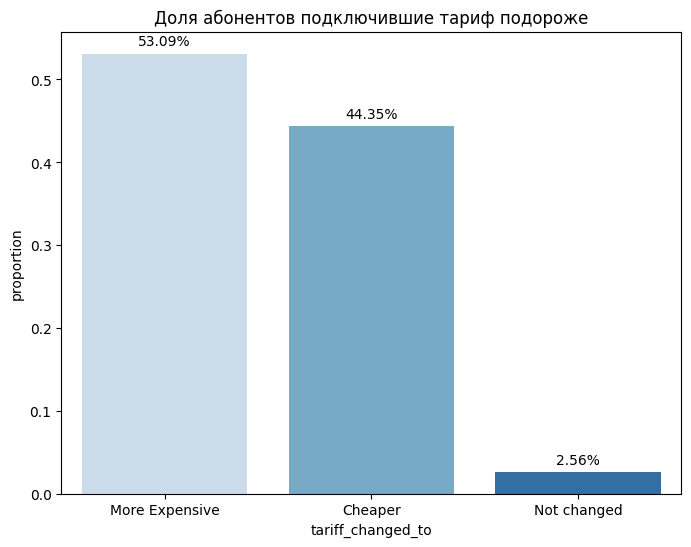

In [ ]:
df_changed_to = pvt_arpu_monthly[((pvt_arpu_monthly["tariff_changed_to"] != "Nan")) & (~pvt_arpu_monthly["ID_NUMBER"].isin(arpu_test_in))]\
  .tariff_changed_to.value_counts(normalize=True).reset_index()

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_changed_to, x="tariff_changed_to", y="proportion", palette='Blues')
plt.title("Доля абонентов подключившие тариф подороже")
for p in ax.patches:
    ax.annotate(format(p.get_height() * 100, '.2f')+"%",
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')
plt.show()

## Q2. Какой процент абонентов повышают среднемесячный уровень АРПУ, после смены тарифного плана?

*Клиенты с категорией "Upsell" составляют -* **47.09%**

<ipython-input-320-6e216730ab1f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_sell_cat, x="DIRECTION_OF_CHANGE", y="proportion", palette='Blues')


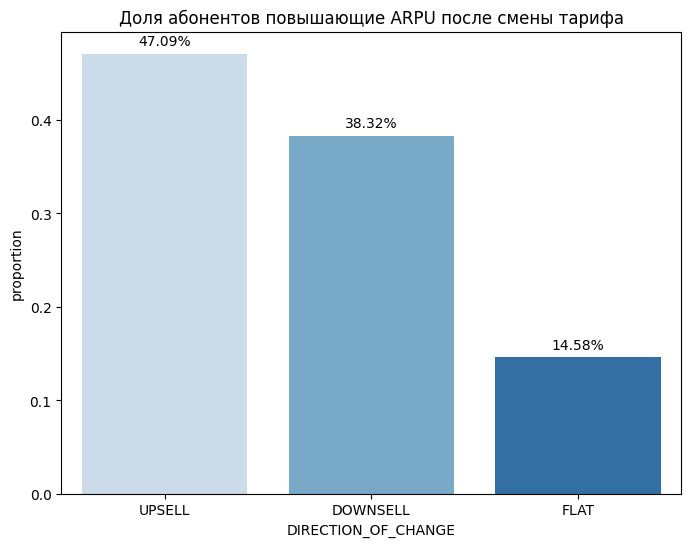

In [ ]:
df_sell_cat = pvt_arpu_monthly[(~pvt_arpu_monthly.tariff_cd_from.isna()) & (~pvt_arpu_monthly["ID_NUMBER"].isin(change_test_in))]\
  .DIRECTION_OF_CHANGE.value_counts(normalize=True).reset_index()

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_sell_cat, x="DIRECTION_OF_CHANGE", y="proportion", palette='Blues')
plt.title("Доля абонентов повышающие ARPU после смены тарифа")
for p in ax.patches:
    ax.annotate(format(p.get_height() * 100, '.2f')+"%",
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')
plt.show()

## Q3. Какой основной параметр влияет на повышение уровня АРПУ, при переходе на другой тариф?
- тарифы абонентов 3, 6 месяцев назад
- квартал даты выдачи девайса

###  X and y

In [ ]:
# Add pvt_traffic in features
# Encode target variable - "DIRECTION_OF_CHANGE" = "Upsell"
df_client = pvt_arpu_monthly[['ID_NUMBER', 'arpu_0mm', 'arpu_1mm', 'arpu_2mm', 'arpu_3mm', 'arpu_4mm',
       'arpu_5mm', 'Data_in_PKG_from',
       'Min_another_operator_in_PKG_from',
       'Min_another_operator_and_city_in_PKG_from', 'price_tariff_from',
       'DIRECTION_OF_CHANGE']]
df_client = df_client.merge(pvt_traffic, on="ID_NUMBER", how="inner")
df_client_train = df_client[~df_client['ID_NUMBER'].isin(arpu_test_in)]
df_client_test = df_client[df_client['ID_NUMBER'].isin(arpu_test_in)]

X_train = df_client_train.drop("DIRECTION_OF_CHANGE", axis=1)
X_test = df_client_test.drop("DIRECTION_OF_CHANGE", axis=1)
y_train = df_client_train["DIRECTION_OF_CHANGE"] == "UPSELL"
y_test = df_client_test["DIRECTION_OF_CHANGE"] == "UPSELL"

In [ ]:
columns = X_train.columns
for col in columns:
  print(col, end='", "')

ID_NUMBER", "arpu_0mm", "arpu_1mm", "arpu_2mm", "arpu_3mm", "arpu_4mm", "arpu_5mm", "Data_in_PKG_from", "Min_another_operator_in_PKG_from", "Min_another_operator_and_city_in_PKG_from", "price_tariff_from", "AVG_DURATION_CONTACT_0mm", "AVG_DURATION_CONTACT_1mm", "AVG_DURATION_CONTACT_2mm", "AVG_DURATION_CONTACT_3mm", "AVG_DURATION_CONTACT_4mm", "AVG_DURATION_CONTACT_5mm", "AVG_TRANSACT_CONTACT_0mm", "AVG_TRANSACT_CONTACT_1mm", "AVG_TRANSACT_CONTACT_2mm", "AVG_TRANSACT_CONTACT_3mm", "AVG_TRANSACT_CONTACT_4mm", "AVG_TRANSACT_CONTACT_5mm", "COUNT_BASE_STATION_0mm", "COUNT_BASE_STATION_1mm", "COUNT_BASE_STATION_2mm", "COUNT_BASE_STATION_3mm", "COUNT_BASE_STATION_4mm", "COUNT_BASE_STATION_5mm", "COUNT_CONTACT_0mm", "COUNT_CONTACT_1mm", "COUNT_CONTACT_2mm", "COUNT_CONTACT_3mm", "COUNT_CONTACT_4mm", "COUNT_CONTACT_5mm", "DATA_VOLUME_0mm", "DATA_VOLUME_1mm", "DATA_VOLUME_2mm", "DATA_VOLUME_3mm", "DATA_VOLUME_4mm", "DATA_VOLUME_5mm", "FIRST_DISP_DIAG_0mm", "FIRST_DISP_DIAG_1mm", "FIRST_DISP_DIAG

In [ ]:
dummy_columns = ["qq_max_issue_device_2", "qq_max_issue_device_3", "qq_max_issue_device_4",
                 #'MAX_OS_1', 'MAX_OS_2', 'MAX_OS_3', 'MAX_OS_4',
                 "OS_1_0mm", "OS_1_1mm", "OS_1_2mm", "OS_1_3mm", "OS_1_4mm", "OS_1_5mm", "OS_2_0mm", "OS_2_1mm", "OS_2_2mm",
                 "OS_2_3mm", "OS_2_4mm", "OS_2_5mm", "OS_3_0mm", "OS_3_1mm", "OS_3_2mm", "OS_3_3mm", "OS_3_4mm", "OS_3_5mm",
                 "OS_4_0mm", "OS_4_1mm", "OS_4_2mm", "OS_4_3mm", "OS_4_4mm", "OS_4_5mm",
                'tariff_cd_0mm_1.0', 'tariff_cd_0mm_2.0', 'tariff_cd_0mm_3.0', 'tariff_cd_0mm_4.0', 'tariff_cd_0mm_5.0',
                 'tariff_cd_0mm_6.0', 'tariff_cd_0mm_7.0', 'tariff_cd_0mm_8.0', 'tariff_cd_0mm_9.0', 'tariff_cd_0mm_10.0',
                 'tariff_cd_0mm_11.0', 'tariff_cd_0mm_12.0', 'tariff_cd_0mm_13.0', 'tariff_cd_0mm_14.0', 'tariff_cd_0mm_15.0',
                 'tariff_cd_0mm_16.0', 'tariff_cd_0mm_17.0', 'tariff_cd_0mm_18.0', 'tariff_cd_0mm_19.0', 'tariff_cd_0mm_20.0',
                 'tariff_cd_1mm_1.0', 'tariff_cd_1mm_2.0', 'tariff_cd_1mm_3.0', 'tariff_cd_1mm_4.0', 'tariff_cd_1mm_5.0',
                 'tariff_cd_1mm_6.0', 'tariff_cd_1mm_7.0', 'tariff_cd_1mm_8.0', 'tariff_cd_1mm_9.0', 'tariff_cd_1mm_10.0',
                 'tariff_cd_1mm_11.0', 'tariff_cd_1mm_12.0', 'tariff_cd_1mm_13.0', 'tariff_cd_1mm_14.0', 'tariff_cd_1mm_15.0',
                 'tariff_cd_1mm_16.0', 'tariff_cd_1mm_17.0', 'tariff_cd_1mm_18.0', 'tariff_cd_1mm_19.0', 'tariff_cd_1mm_20.0',
                 'tariff_cd_2mm_1.0', 'tariff_cd_2mm_2.0', 'tariff_cd_2mm_3.0', 'tariff_cd_2mm_4.0', 'tariff_cd_2mm_5.0',
                 'tariff_cd_2mm_6.0', 'tariff_cd_2mm_7.0', 'tariff_cd_2mm_8.0', 'tariff_cd_2mm_9.0', 'tariff_cd_2mm_10.0',
                 'tariff_cd_2mm_11.0', 'tariff_cd_2mm_12.0', 'tariff_cd_2mm_13.0', 'tariff_cd_2mm_14.0', 'tariff_cd_2mm_15.0',
                 'tariff_cd_2mm_16.0', 'tariff_cd_2mm_17.0', 'tariff_cd_2mm_18.0', 'tariff_cd_2mm_19.0', 'tariff_cd_2mm_20.0',
                 'tariff_cd_2mm_21.0', 'tariff_cd_3mm_1.0', 'tariff_cd_3mm_2.0', 'tariff_cd_3mm_3.0', 'tariff_cd_3mm_4.0',
                 'tariff_cd_3mm_5.0', 'tariff_cd_3mm_6.0', 'tariff_cd_3mm_7.0', 'tariff_cd_3mm_8.0', 'tariff_cd_3mm_9.0',
                 'tariff_cd_3mm_10.0', 'tariff_cd_3mm_11.0', 'tariff_cd_3mm_12.0', 'tariff_cd_3mm_13.0', 'tariff_cd_3mm_14.0',
                 'tariff_cd_3mm_15.0', 'tariff_cd_3mm_16.0', 'tariff_cd_3mm_17.0', 'tariff_cd_3mm_18.0', 'tariff_cd_3mm_19.0',
                 'tariff_cd_3mm_20.0', 'tariff_cd_3mm_21.0', 'tariff_cd_4mm_1.0', 'tariff_cd_4mm_2.0', 'tariff_cd_4mm_3.0',
                 'tariff_cd_4mm_4.0', 'tariff_cd_4mm_5.0', 'tariff_cd_4mm_6.0', 'tariff_cd_4mm_7.0', 'tariff_cd_4mm_8.0',
                 'tariff_cd_4mm_9.0', 'tariff_cd_4mm_10.0', 'tariff_cd_4mm_11.0', 'tariff_cd_4mm_12.0', 'tariff_cd_4mm_13.0',
                 'tariff_cd_4mm_14.0', 'tariff_cd_4mm_15.0', 'tariff_cd_4mm_16.0', 'tariff_cd_4mm_17.0', 'tariff_cd_4mm_18.0',
                 'tariff_cd_4mm_19.0', 'tariff_cd_4mm_20.0', 'tariff_cd_5mm_1.0', 'tariff_cd_5mm_2.0', 'tariff_cd_5mm_3.0',
                 'tariff_cd_5mm_4.0', 'tariff_cd_5mm_5.0', 'tariff_cd_5mm_6.0', 'tariff_cd_5mm_7.0', 'tariff_cd_5mm_8.0',
                 'tariff_cd_5mm_9.0', 'tariff_cd_5mm_10.0', 'tariff_cd_5mm_11.0', 'tariff_cd_5mm_12.0', 'tariff_cd_5mm_13.0',
                 'tariff_cd_5mm_14.0', 'tariff_cd_5mm_15.0', 'tariff_cd_5mm_16.0', 'tariff_cd_5mm_17.0', 'tariff_cd_5mm_18.0',
                 'tariff_cd_5mm_19.0', 'tariff_cd_5mm_20.0', 'tariff_cd_5mm_21.0']


### StandardScaler

In [ ]:
scaler = StandardScaler()

X_dummy_train = X_train[dummy_columns].values
X_num_train = X_train.drop(dummy_columns, axis=1).values

X_dummy_test = X_test[dummy_columns].values
X_num_test = X_test.drop(dummy_columns, axis=1).values

X_num_train = scaler.fit_transform(X_num_train)
X_num_test = scaler.transform(X_num_test)

X_train = np.concatenate((X_dummy_train, X_num_train), axis=1)
X_test = np.concatenate((X_dummy_test, X_num_test), axis=1)

Поиск найлучшей модели и параметров

In [ ]:
# models = {"logreg":  [LogisticRegression(solver="liblinear", penalty="l1"), {"C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}]}#"newton-cholesky"
# kf = KFold(n_splits=6, shuffle=True, random_state=42)
# for model, param in models.values():
#   cv = GridSearchCV(model, param_grid=param, cv=kf, scoring='accuracy')
#   cv.fit(X_train, y_train)
#   print(str(model))
#   print(cv.best_estimator_, cv.best_score_)
#   # LogisticRegression(C=0.1, penalty='l1', solver='liblinear') 0.6412031066117582

### Logistic Regression

In [ ]:
logreg = LogisticRegression(C=0.1, solver="liblinear", penalty="l1")
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

### Metrics

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
coef_list = []
for col, coef in zip(columns, logreg.coef_.reshape(-1,1)):
  coef_list.append([col, abs(coef[0])])
coef_df = pd.DataFrame(coef_list)
coef_df = coef_df.sort_values(1, ascending=False)[:10]

[[10061  1869]
 [ 7822  2413]]
              precision    recall  f1-score   support

       False       0.56      0.84      0.67     11930
        True       0.56      0.24      0.33     10235

    accuracy                           0.56     22165
   macro avg       0.56      0.54      0.50     22165
weighted avg       0.56      0.56      0.52     22165



В виду того, что класс "Upsell" имеет вес в 50% в выборке, то есть мы не имеем в выборке "imbalance in classes", метрикой оценки выбираем - **accuracy**.

<ipython-input-328-7be3ad411cbe>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x=0, y=1,  palette='Blues')


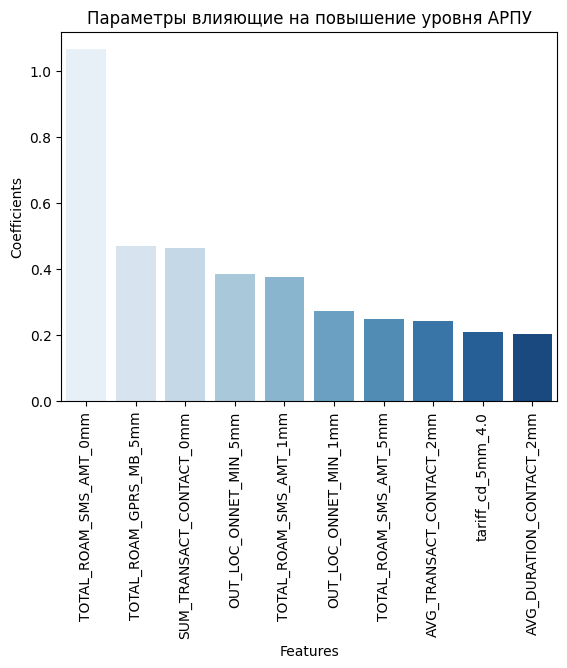

In [ ]:
sns.barplot(data=coef_df, x=0, y=1,  palette='Blues')
plt.title("Параметры влияющие на повышение уровня АРПУ")
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.show()

## Q4. Каков профиль абонента, который с большей долей вероятности понизит уровень АРПУ при переходе на другой тариф.

- АРПУ 4000-10000 тенге
- Текущий тариф - 5, 6, 8, 14
- Количество смен тарифных планов не входит в профиль такого клиента

### Распределение по "АРПУ"

In [ ]:
df = pvt_arpu_monthly.merge(pvt_traffic, on="ID_NUMBER", how="inner")
df = df[~df.ID_NUMBER.isin(arpu_test_in)]
df_downsell = df[df["DIRECTION_OF_CHANGE"]=="DOWNSELL"]

<ipython-input-330-ac81b947d279>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  p = sns.histplot(data=df_downsell, x="total_arpu", bins=range(0, 45000, 2000), palette='Blues')


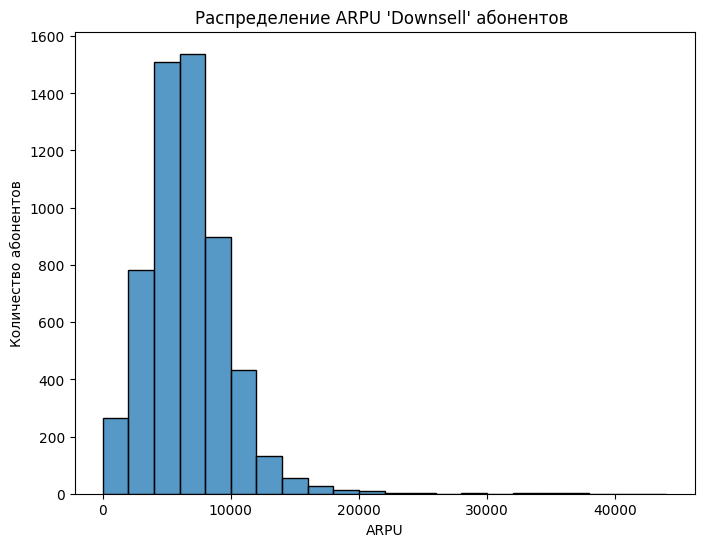

In [ ]:
plt.figure(figsize=(8, 6))
p = sns.histplot(data=df_downsell, x="total_arpu", bins=range(0, 45000, 2000), palette='Blues')
p.set(xlabel="ARPU", ylabel="Количество абонентов")
plt.title("Распределение ARPU 'Downsell' абонентов ")
plt.show()

### Распределение по тарифным планам.

<ipython-input-331-ebd357bd6296>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.countplot(data=df_downsell, x="tariff_cd_from", palette='Blues')


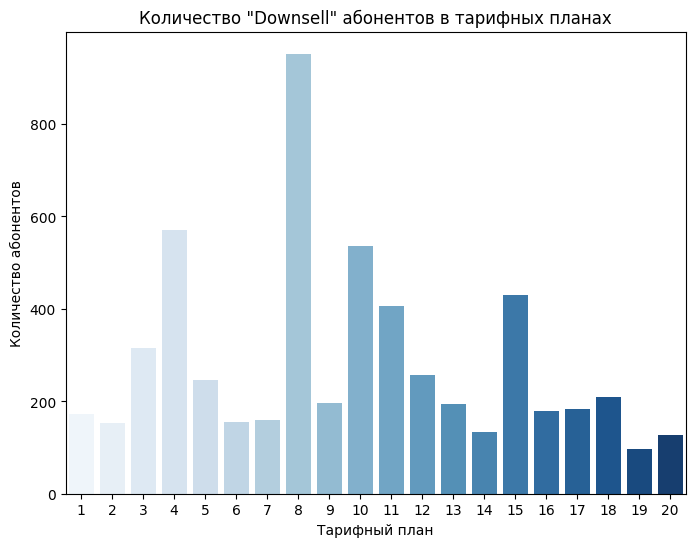

In [ ]:
plt.figure(figsize=(8, 6))
p = sns.countplot(data=df_downsell, x="tariff_cd_from", palette='Blues')
p.set(xlabel="Тарифный план", ylabel="Количество абонентов")
plt.title('Количество "Downsell" абонентов в тарифных планах')
plt.show()

<ipython-input-332-0486f8907550>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_tariff_all, x="tariff_cd_from", y="proportion", palette='Blues')


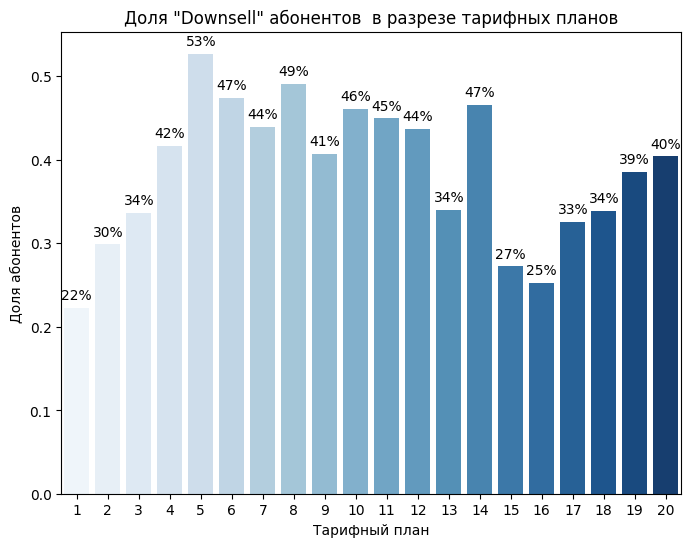

In [ ]:
df_tariff_downsell = df[df.DIRECTION_OF_CHANGE == "DOWNSELL"].tariff_cd_from.value_counts().reset_index()
df_tariff_all = df.tariff_cd_from.value_counts().reset_index()
df_tariff_all = df_tariff_all.merge(df_tariff_downsell, on="tariff_cd_from", how="left")
df_tariff_all["proportion"] = df_tariff_all.count_y / df_tariff_all.count_x
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_tariff_all, x="tariff_cd_from", y="proportion", palette='Blues')
plt.title('Доля "Downsell" абонентов  в разрезе тарифных планов')
for p in ax.patches:
    ax.annotate(format(p.get_height() * 100, '.0f')+"%",
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')
ax.set(xlabel="Тарифный план", ylabel="Доля абонентов")
plt.show()

### Распределение по количеству смен тарифных планов

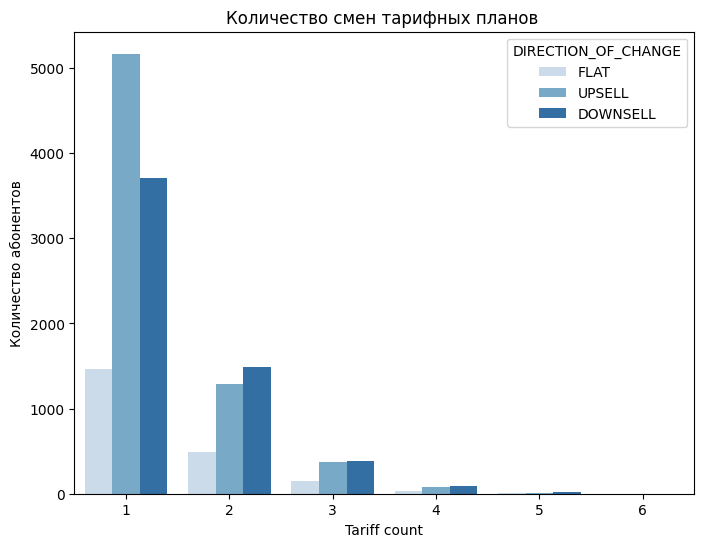

In [ ]:
plt.figure(figsize=(8, 6))
p = sns.countplot(data=df[(df["tariff_count"] > 0) & (df["DIRECTION_OF_CHANGE"] != "0")], x="tariff_count", palette='Blues', hue="DIRECTION_OF_CHANGE")
p.set(xlabel="Tariff count", ylabel="Количество абонентов")
plt.title("Количество смен тарифных планов ")
plt.show()

## Q5. Какой самый популярный тарифный план и опишите основные причины перехода на данный тариф
- тариф 8
-увеличили мегабайты и минуты на других операторов, снизили минуты на городские номера
- снизили потребление и цену соответственно

In [ ]:
# Detect top tariff to switch
(pvt_arpu_monthly[~pvt_arpu_monthly.ID_NUMBER.isin(arpu_test_in)]["tariff_cd_to"]\
  .value_counts(normalize=True) *100).round().reset_index()

,tariff_cd_to,proportion
0,8,32.0
1,10,13.0
2,4,13.0
3,13,12.0
4,9,9.0
5,11,8.0
6,1,6.0
7,12,5.0
8,21,2.0


In [ ]:
df_tariff_8 = pvt_arpu_monthly[(pvt_arpu_monthly["tariff_cd_to"] == 8)  & (~pvt_arpu_monthly.ID_NUMBER.isin(arpu_test_in))]

Text(0.5, 0, 'Tenge')

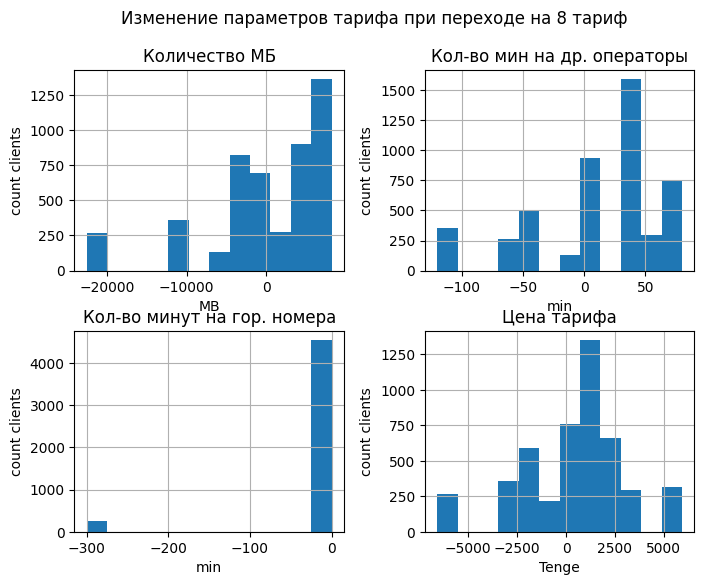

In [ ]:
ax = df_tariff_8[["diff_data", "diff_min_opers", "diff_min_opers_city", "diff_price_tariff"]].hist(bins=12, figsize=(8, 6))
ax[0, 0].set_title('Количество МБ')
ax[0, 1].set_title('Кол-во мин на др. операторы')
ax[1, 0].set_title('Кол-во минут на гор. номера')
ax[1, 1].set_title('Цена тарифа')
plt.suptitle("Изменение параметров тарифа при переходе на 8 тариф")
ax[0, 0].set_ylabel("count clients")
ax[0, 1].set_ylabel("count clients")
ax[1, 0].set_ylabel("count clients")
ax[1, 1].set_ylabel("count clients")
ax[0, 0].set_xlabel("MB")
ax[0, 1].set_xlabel("min")
ax[1, 0].set_xlabel("min")
ax[1, 1].set_xlabel("Tenge")

## Q6. Провести когортный анализ в разрезе месячных АРПУ, и выявить паттерны поведения которые влияют на downsell или upsell

- в первый месяц паттерн Upsell
- во второй месяй Downsell
- с третьего месяца постепенный рост АРПУ

In [ ]:
# Detecting cohorts on action - tariff_change
columns = ['tariff_cd_0mm', 'tariff_cd_1mm', 'tariff_cd_2mm',
       'tariff_cd_3mm', 'tariff_cd_4mm', 'tariff_cd_5mm']

for num, column in enumerate(columns[:-1]):
  index = str(num + 1) + "_cohort"
  df_cohort[index] = (df_cohort[column] == df_cohort[columns[num + 1]])

In [ ]:
# Формируем свод по когортам
arpu = ['arpu_0mm', 'arpu_1mm', 'arpu_2mm', 'arpu_3mm', 'arpu_4mm', 'arpu_5mm']
cohorts = ["1_cohort", "2_cohort", "3_cohort", "4_cohort", "5_cohort"]
pvt_cohort = pd.DataFrame(columns= arpu)
exclude_set=set()
for num, cohort in enumerate(cohorts):
  # Определяем когорты по действию смены тарифа
  df_cohort_n = df_cohort[df_cohort[cohort] == False]
  # В последующих когортах исключаем клиентов определенные в когорты ранее
  if num > 0:
    exclude_set.update(df_cohort[df_cohort[cohorts[num - 1]] == False]["ID_NUMBER"].values)
    df_cohort_n = df_cohort_n[~df_cohort_n["ID_NUMBER"].isin(exclude_set)]
  df_cohort_n[cohort] = cohort
  # Рассчитываем средний АРПУ в когорте по месяцам
  pvt_cohort_n = pd.pivot_table(df_cohort_n, index=cohort, values=arpu, aggfunc="mean")
  pvt_cohort = pd.concat([pvt_cohort, pvt_cohort_n])

<ipython-input-338-4d3c03d20ede>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cohort_n[cohort] = cohort


In [ ]:
pvt_cohort

,arpu_0mm,arpu_1mm,arpu_2mm,arpu_3mm,arpu_4mm,arpu_5mm
1_cohort,3358.262808,3906.613816,3512.951464,3536.678412,3571.499896,3843.178037
2_cohort,3707.819900,3616.682505,3939.577317,3477.222308,3637.903338,3845.963465
3_cohort,3856.507303,3484.644225,3568.673010,4077.572453,3818.865133,4055.160626
4_cohort,3997.385211,3954.193439,3942.432357,3974.241600,5161.615747,4062.839547
5_cohort,3919.605212,4089.288890,4185.635431,4024.411720,3856.483867,4329.901677


In [ ]:
 # Удаляем АРПУ по когортам до даты смены когорты
# Диагональ это начальное значение когорты - переносим
for val in range(1, 5):
  pvt_cohort.iloc[val, 0] = pvt_cohort.iloc[val, val]
  pvt_cohort.iloc[val, val] = 0

# До диагонали удаляем - т.к. на тот момент не было смены тарифа по данным когортам
for row in range(2, 5):
  for col in range(1, row):
    pvt_cohort.iloc[row, col] = 0

 # Упорядочиваем суммы АРПУ по сроку жизни когорты
for num in range(0, 4):
  for row in range(1 + num, 5):
    for col in range(1, 5):
      pvt_cohort.iloc[row, col] = pvt_cohort.iloc[row, col + 1]
      pvt_cohort.iloc[row, col + 1] = None

In [ ]:
pvt_cohort

,arpu_0mm,arpu_1mm,arpu_2mm,arpu_3mm,arpu_4mm,arpu_5mm
1_cohort,3358.262808,3906.613816,3512.951464,3536.678412,3571.499896,3843.178037
2_cohort,3616.682505,3939.577317,3477.222308,3637.903338,3845.963465,NaN
3_cohort,3568.673010,4077.572453,3818.865133,4055.160626,NaN,NaN
4_cohort,3974.241600,5161.615747,4062.839547,NaN,NaN,NaN
5_cohort,3856.483867,4329.901677,NaN,NaN,NaN,NaN


In [ ]:
# Транспонируем для графика
df_trans = pvt_cohort.transpose()
df_trans

,1_cohort,2_cohort,3_cohort,4_cohort,5_cohort
arpu_0mm,3358.262808,3616.682505,3568.673010,3974.241600,3856.483867
arpu_1mm,3906.613816,3939.577317,4077.572453,5161.615747,4329.901677
arpu_2mm,3512.951464,3477.222308,3818.865133,4062.839547,NaN
arpu_3mm,3536.678412,3637.903338,4055.160626,NaN,NaN
arpu_4mm,3571.499896,3845.963465,NaN,NaN,NaN
arpu_5mm,3843.178037,NaN,NaN,NaN,NaN


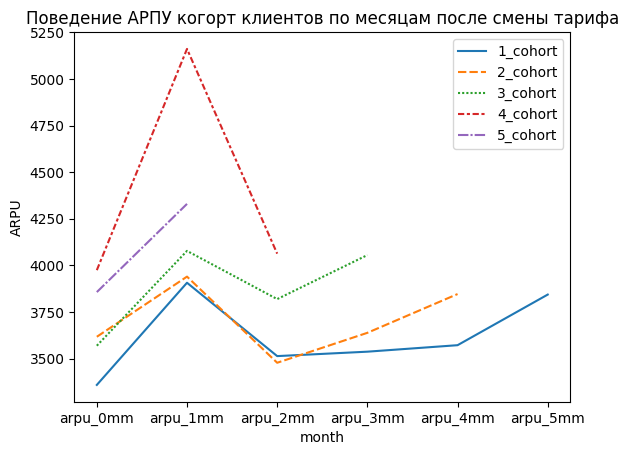

In [ ]:
ax = sns.lineplot(data=df_trans)
ax.set_title("Поведение АРПУ когорт клиентов по месяцам после смены тарифа")
ax.set(xlabel="month", ylabel="ARPU")
plt.show()

# PROBLEM II: АЛГОРИТМ РЕКОМЕНДАЦИИ ТАРИФА

## Q1. Какой процент рекомендованных тарифов совпал с реальным выбором клиента в валидационной выборке?
-- 20%

In [ ]:
df_client = pvt_arpu_monthly[['ID_NUMBER', 'arpu_0mm', 'arpu_1mm', 'arpu_2mm', 'arpu_3mm', 'arpu_4mm',
       'arpu_5mm', 'Data_in_PKG_from',
       'Min_another_operator_in_PKG_from',
       'Min_another_operator_and_city_in_PKG_from', 'price_tariff_from', 'tariff_cd_to']]
df_client = df_client.merge(pvt_traffic, on="ID_NUMBER", how="inner")
df_client_train = df_client[~df_client['ID_NUMBER'].isin(arpu_test_in)]
df_client_test = df_client[df_client['ID_NUMBER'].isin(arpu_test_in)]

X_train = df_client_train.drop("tariff_cd_to", axis=1)
X_test = df_client_test.drop("tariff_cd_to", axis=1)
y_train = df_client_train["tariff_cd_to"].values
y_test = df_client_test["tariff_cd_to"].values

In [ ]:
scaler = StandardScaler()

X_dummy_train = X_train[dummy_columns].values
X_num_train = X_train.drop(dummy_columns, axis=1).values

X_dummy_test = X_test[dummy_columns].values
X_num_test = X_test.drop(dummy_columns, axis=1).values

X_num_train = scaler.fit_transform(X_num_train)
X_num_test = scaler.transform(X_num_test)

X_train = np.concatenate((X_dummy_train, X_num_train), axis=1)
X_test = np.concatenate((X_dummy_test, X_num_test), axis=1)

In [ ]:
smote =  SMOTE(random_state=42)
X_resampled, y_resampled =  smote.fit_resample(X_train, y_train)

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_resampled, y_resampled)

y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           4       0.16      0.08      0.11      3856
           8       0.28      0.34      0.31      6921
           9       0.01      0.11      0.02        98
          10       0.16      0.18      0.17      3761
          11       0.11      0.15      0.13      2485
          12       0.07      0.11      0.09      1104
          13       0.51      0.26      0.34      2104
          14       0.00      0.00      0.00      1803
          16       0.00      0.00      0.00         1
          21       0.00      0.00      0.00        32

    accuracy                           0.20     22165
   macro avg       0.12      0.11      0.11     22165
weighted avg       0.21      0.20      0.20     22165



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
flag = y_test == y_pred
column_names = ["y_test","y_pred", "flag"]
df = pd.DataFrame(zip(y_test, y_pred, flag), columns=column_names)

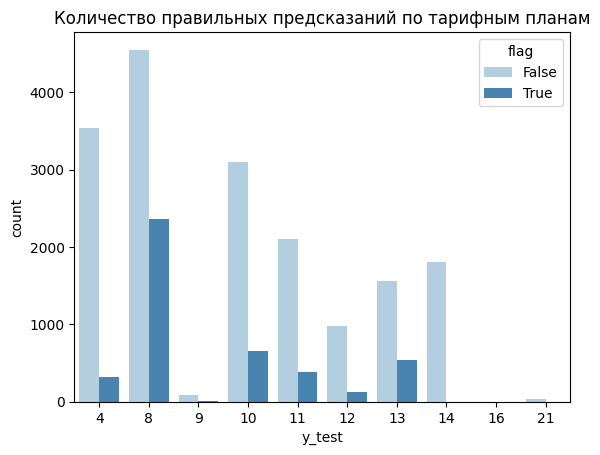

In [ ]:
sns.countplot(x="y_test", data=df, hue="flag", palette="Blues")
plt.title("Количество правильных предсказаний по тарифным планам")
plt.show()

##Q2. Какой процент из выборки, в которой выбранный тарифный план совпал с рекомендуемым, снизили свой revenue или повысили свой revenue после перехода на другой тариф?
* 52.5% повысили,
* 34.1% снизили АРПУ

In [ ]:
df_client_test["flag"] = flag


<ipython-input-349-92d7bf5b1337>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_client_test["flag"] = flag


In [ ]:
condition = df_client_test[df_client_test["flag"] == True]["ID_NUMBER"]
df = pvt_arpu_monthly[pvt_arpu_monthly['ID_NUMBER'].isin(condition)]

<ipython-input-351-c563df167c5d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_sell_cat, x="DIRECTION_OF_CHANGE", y="proportion", palette='Blues')


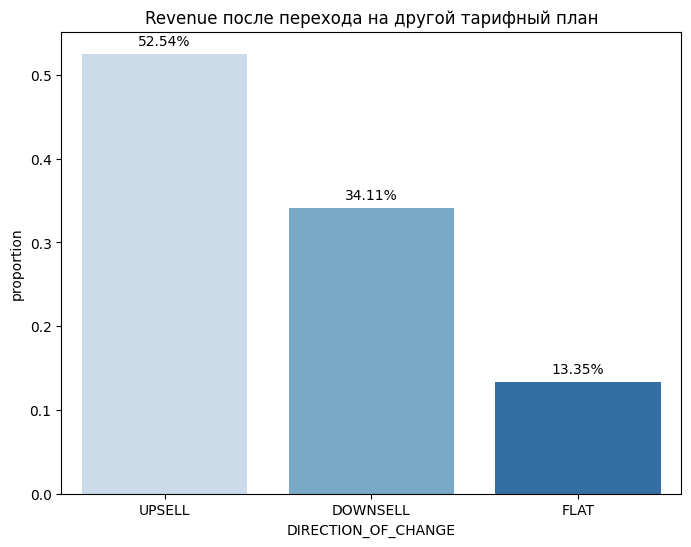

In [ ]:
df_sell_cat = df.DIRECTION_OF_CHANGE.value_counts(normalize=True).reset_index()

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_sell_cat, x="DIRECTION_OF_CHANGE", y="proportion", palette='Blues')
plt.title("Revenue после перехода на другой тарифный план")
for p in ax.patches:
    ax.annotate(format(p.get_height() * 100, '.2f')+"%",
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')
plt.show()

##Q3. Чему равно среднее(AVG_ARPU_NEXT_3M - AVG_ARPU_PREV_3M) по абонентам, для которых правильно порекомендовали тарифы

-- 863 тенге средняя разница АРПУ

In [ ]:
df["diff_arpu_3m"] = df["AVG_ARPU_NEXT_3M"] - df["AVG_ARPU_PREV_3M"]
df["diff_arpu_3m_abs"] = abs(df["AVG_ARPU_NEXT_3M"] - df["AVG_ARPU_PREV_3M"])

<ipython-input-352-f58545be51b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["diff_arpu_3m"] = df["AVG_ARPU_NEXT_3M"] - df["AVG_ARPU_PREV_3M"]
<ipython-input-352-f58545be51b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["diff_arpu_3m_abs"] = abs(df["AVG_ARPU_NEXT_3M"] - df["AVG_ARPU_PREV_3M"])


Text(0.5, 1.0, 'Распределение разницы АРПУ_3мес после смены тарифа')

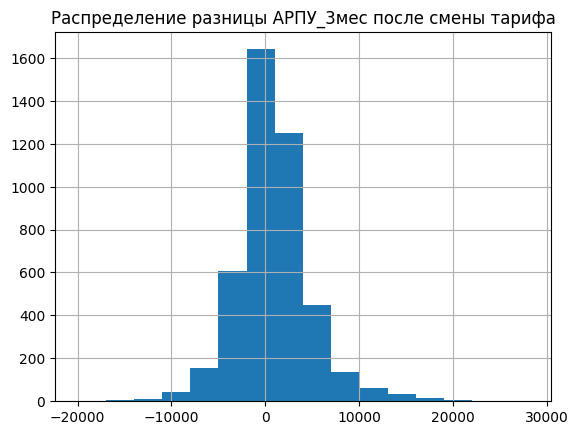

In [ ]:
df["diff_arpu_3m"].hist(bins=range(-20000, 30000, 3000))
plt.title("Распределение разницы АРПУ_3мес после смены тарифа")

In [ ]:
df["diff_arpu_3m"].describe()

count      4418.000000
mean        863.425557
std        7206.804404
min     -339029.350000
25%       -1261.822500
50%         540.275000
75%        2850.445000
max      183114.330000
Name: diff_arpu_3m, dtype: float64

##Q4.	Какой процент из выборки, в которой выбранный тарифный план совпал с рекомендуемым, снизили свой revenue или повысили свой revenue после перехода на тариф, который выше по цене
* 60.86% повысили АРПУ при переходе на тариф подороже.

In [ ]:
df = df[df["tariff_changed_to"] == "More Expensive"]

<ipython-input-356-c563df167c5d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_sell_cat, x="DIRECTION_OF_CHANGE", y="proportion", palette='Blues')


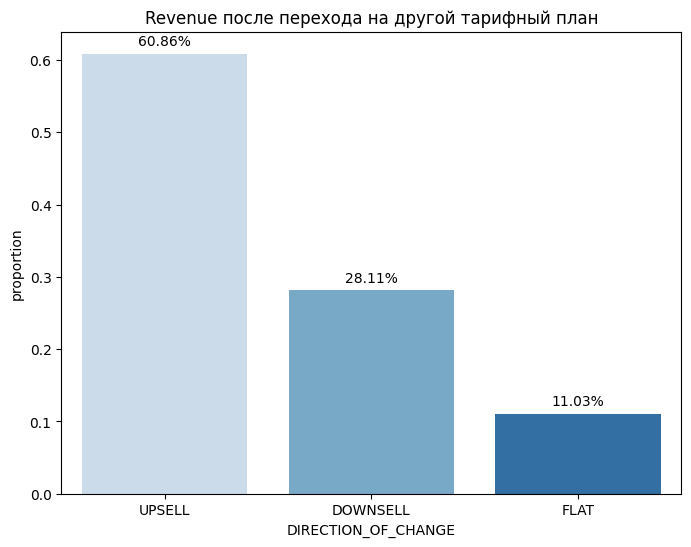

In [ ]:
df_sell_cat = df.DIRECTION_OF_CHANGE.value_counts(normalize=True).reset_index()

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_sell_cat, x="DIRECTION_OF_CHANGE", y="proportion", palette='Blues')
plt.title("Revenue после перехода на другой тарифный план")
for p in ax.patches:
    ax.annotate(format(p.get_height() * 100, '.2f')+"%",
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')
plt.show()